### School of Innovation Technologies and Engineering

Department of Industrial System Engineering


---



# Interim Report
## Mauritian Sign Language System with Machine Learning

MSC Computer Science with Emerging Technologies

**MSc Dissertation**

**Module code: MCSET23BPT**


Name: Noyan Tsurishaddaï


Student ID: 2310_26618


Academic Year: 2024-2025


Submission Date: 23 March 2025



In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install scikeras

In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==4.11.0.86

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88


In [ ]:
!pip install mediapipe==0.10.21

In [ ]:
# importing libraries and related module
import tensorflow
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

from keras_tuner import RandomSearch

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image # import Image
import mediapipe as mp


Step 1: data preprocessing

In [ ]:
# check if file path exist
file_path = '/content/drive/MyDrive/Colab Notebooks/add_miss_sign_mnist_train.csv'

if not os.path.exists(file_path):
    print(f"Error: Data file '{file_path}' does not exist.")
else:
    print(f"Data file '{file_path}' exists. Loading data...")
    # Reading the sign language dataset as 'asl_data'
    asl_data = pd.read_csv(file_path)
    print("Data loaded successfully.")

Data file '/content/drive/MyDrive/Colab Notebooks/add_miss_sign_mnist_train.csv' exists. Loading data...
Data loaded successfully.


In [ ]:
# Displaying first 5 in the row
print(asl_data.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

In [ ]:
# Display the shape of the original dataset
print(f"Original dataset has {asl_data.shape[0]} rows and {asl_data.shape[1]} columns.")

Original dataset has 27455 rows and 785 columns.


In [ ]:
dataset_size = asl_data.shape[0]
print(f"Dataset size: {dataset_size}")

Dataset size: 27455


In [ ]:
# Proper loading and preprocessing of the Sign Language dataset
# separate the features and labels:
# train_images = asl_data.drop(columns=['filename']).iloc[:, 1:].values
train_images = asl_data.iloc[:, 1:].values
train_labels = asl_data.iloc[:, 0].values

# test_images = asl_data.drop(columns=['filename']).iloc[:, 1:].values
test_images = asl_data.iloc[:, 1:].values
test_labels = asl_data.iloc[:, 0].values

In [ ]:
# normalise
train_images = train_images / 255.0  # Normalize pixel values to the range [0, 1]
test_images = test_images / 255.0

In [ ]:
test_images = test_images / 255.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image(letter1, letter2):
    # Combine pixel values of two letters
    combined_pixels = (letter1 + letter2) / 2
    return combined_pixels

# Example: Generate synthetic image for J (combining I and K)
# Assuming 'label' is the name of the first column containing the label (0-25 for a-z)
# Accessing data for label 8 (i)
i_pixels = asl_data.loc[asl_data['label'] == 8].drop('label', axis=1).values[0]
# Accessing data for label 10 (k)
k_pixels = asl_data.loc[asl_data['label'] == 10].drop('label', axis=1).values[0]
j_pixels = generate_image(i_pixels, k_pixels)

# Reshape to 28x28, ensuring the correct number of elements (784)
# j_pixels = j_pixels.reshape(28, 28) # Changed from j_pixels.reshape(28, 28)


# Display the synthetic image
# plt.imshow(j_pixels, cmap='gray')
# plt.title('Synthetic Image for J')
# plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_j():
    img = np.ones((28, 28), dtype=np.uint8) * 255  # white background
    # Draw a curved line resembling the letter 'J'
    cv2.polylines(img, [np.array([[14, 10], [12, 15], [14, 20], [16, 25], [18, 20], [16, 15], [14, 10]], dtype=np.int32)], isClosed=False, color=0, thickness=2)
    return img

def draw_z():
    img = np.ones((28, 28), dtype=np.uint8) * 255  # white background
    # Draw a 'Z' shape
    cv2.line(img, (6, 6), (20, 6), 0, 2)  # top horizontal line
    cv2.line(img, (20, 6), (10, 14), 0, 2)  # diagonal line
    cv2.line(img, (10, 14), (6, 22), 0, 2)  # bottom diagonal line
    cv2.line(img, (6, 22), (20, 22), 0, 2)  # bottom horizontal line
    return img

# Generate and display the images
j_img = draw_j()
z_img = draw_z()


In [ ]:
import os
import cv2

new_data_dir = "/content/drive/MyDrive/dissertation/MSL/Sprint/Sprint_2/add_missing_alpha.gsheet"

# using the new data directory to add missing alphabets


# for filename in os.listdir(new_data_dir):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         img_path = os.path.join(new_data_dir, filename)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale
        # ... (append img and label to existing data)

In [ ]:
# creating dataset entries
data = []
labels = []


In [ ]:
# landmark detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()


In [ ]:
#  creating a list to store theimages and their corresponding labels: label 9 (j) and label 25 (z)

new_images = [j_img, z_img]
new_labels = [9, 25]

In [ ]:
# creating a list to store numbers as well as their corresponding labels such as: label 26 (0) till label 35 (9)
# new_images = [img0, img1, img2, img3, img4, img5, img6, img7, img8, img9]
# new_labels = [26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

In [ ]:
# Preprocess the images

#  reshape and normalise the images to be compatible with model's format

new_images = np.array(new_images)
new_images = new_images.reshape(-1, 28, 28, 1)
new_images = new_images / 255.0 # Normalize to [0, 1]

In [ ]:
# Combining with existing data
train_images = train_images.reshape(-1, 28, 28, 1) # Reshape train_images to have 4 dimensions
train_images = np.concatenate([train_images, new_images])
train_labels = np.concatenate([train_labels, new_labels])

In [ ]:
# normalise
train_images = train_images / 255.0  # Normalize pixel values to the range [0, 1]

In [ ]:
print(asl_data['label'].unique())

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


In [ ]:
print(asl_data['label'] == 9)

0        False
1        False
2        False
3        False
4        False
         ...  
27450    False
27451    False
27452    False
27453    False
27454    False
Name: label, Length: 27455, dtype: bool


In [ ]:
# Check the unique classes in the target variable
num_classes = asl_data['label'].nunique()
print(f'Number of unique classes: {num_classes}')  # Should print 24

Number of unique classes: 24


In [ ]:
# As the dataset is huge, therefore, 100% is selected first to train the data and will gradually progess till 100%
# subset_fraction = 1
# subset_size_train = int(len(train_images)* subset_fraction)
# subset_size_test = int(len(test_images)* subset_fraction)

# train_images, train_labels = train_images[:subset_size_train], train_labels[:subset_size_train]
# test_images, test_labels = test_images[:subset_size_test], test_labels[:subset_size_test]


In [ ]:
# Convert train_labels to a consistent data type (e.g., int)
# train_labels = train_labels.astype(int)
# get unique class labels from the training labels
unique_labels = np.unique(train_labels)

# Print the unique class labels
print("Unique class labels in the dataset:")
print(unique_labels)

Unique class labels in the dataset:
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [ ]:
# define a class name to link the label with the alphabets
class_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
               'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Print the class names
print("Sign Language classes:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Sign Language classes:
0: a
1: b
2: c
3: d
4: e
5: f
6: g
7: h
8: i
9: j
10: k
11: l
12: m
13: n
14: o
15: p
16: q
17: r
18: s
19: t
20: u
21: v
22: w
23: x
24: y
25: z


In [ ]:
print(asl_data['label'].unique)

<bound method Series.unique of 0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64>


In [ ]:
print(asl_data[asl_data['label'] == 9].shape)

(0, 785)


In [ ]:
print(asl_data[asl_data['label'] == 25].shape)

(0, 785)


In [ ]:
# Count occurrences of each label in the training dataset
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Print the details of unique labels and their counts
print("Label details:")
for label, count in zip(unique_labels, counts):
    print(f'Label {label} ({class_names[label]}): {count} samples')

Label details:
Label 0 (a): 1126 samples
Label 1 (b): 1010 samples
Label 2 (c): 1144 samples
Label 3 (d): 1196 samples
Label 4 (e): 957 samples
Label 5 (f): 1204 samples
Label 6 (g): 1090 samples
Label 7 (h): 1013 samples
Label 8 (i): 1162 samples
Label 10 (k): 1114 samples
Label 11 (l): 1241 samples
Label 12 (m): 1055 samples
Label 13 (n): 1151 samples
Label 14 (o): 1196 samples
Label 15 (p): 1088 samples
Label 16 (q): 1279 samples
Label 17 (r): 1294 samples
Label 18 (s): 1199 samples
Label 19 (t): 1186 samples
Label 20 (u): 1161 samples
Label 21 (v): 1082 samples
Label 22 (w): 1225 samples
Label 23 (x): 1164 samples
Label 24 (y): 1118 samples


In [ ]:
# adding missing values "J", "Z" images


In [ ]:
# collecting images from webcam

# importing dependencies
import cv2
import os
import time
import uuid


from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time


In [ ]:
# creating Image path
img_path = '/content/drive/MyDrive/Colab'

In [ ]:
# defining the labels and images to collect

# j, z and 0-9

# setting up an array of labels and number of images to collect

labels = ['j', 'k']
number_imgs = 5

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

name 'js_to_image' is not defined


In [ ]:
# collect images
for label in labels:
  # if label doesn't exist, create a dictionary
  label_dir = os.path.join(img_path, label)
  if not os.path.exists(label_dir):
  #   os.makedirs(label_dir)
    !mkdir {'/content/drive/MyDrive/Colab/' +label}
  # else, the label exist, return true
  os.makedirs(label_dir, exist_ok=True)

  cap = cv2.VideoCapture(0)

  if not cap.isOpened():
      print(f"Error: Could not open camera for {label}.")
      # Skip to the next label if camera cannot be opened
      continue

  print('Collecting images for {}'.format(label))
  time.sleep(5)
  for imgnum in range(number_imgs):
    ret, frame = cap.read()

    # check in frame was successfully captured
    if ret:
      imgname = os.path.join(img_path, label, label+'.'+'{}.jpg'.format(str(uuid.uuid1())))
      cv2.imwrite(imgname, frame)
      cv2.imshow('frame', frame)
      time.sleep(5)

      if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    else:
      print(f"Warning: Could not capture frame {imgnum + 1} for {label}. Skipping.")

  cap.release()
  cv2.destroyAllWindows()

Error: Could not open camera for j.
Error: Could not open camera for k.


In [ ]:
from google.colab import drive
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image, HTML
from base64 import b64decode
import cv2
import numpy as np
import PIL.Image
import io
import os
import time # Import time if you need delays

# Mount Google Drive
drive.mount('/content/drive')

# Helper function to convert JS data URL to OpenCV image (you already have this)
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# JavaScript code to open camera and provide a capture function
js_camera_setup = Javascript('''
    async function setupCamera() {
      const video = document.createElement('video');
      const liveView = document.getElementById('liveView'); // Assuming you have a div with id 'liveView'
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      liveView.innerHTML = ''; // Clear previous content
      liveView.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Function to capture photo and return data URL
      window.capturePhoto = async function(quality = 0.8) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        return canvas.toDataURL('image/jpeg', quality);
      };

       // Function to stop the camera stream
      window.stopCamera = function() {
          const stream = video.srcObject;
          if (stream) {
              stream.getTracks().forEach(track => track.stop());
          }
          liveView.innerHTML = ''; // Clear the video element
      };

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
    }
''')

# HTML to display controls and live view
camera_ui = HTML('''
<button id="openCameraBtn">Open Camera</button>
<button id="closeCameraBtn" disabled>Close Camera</button>
<div id="liveView"></div>
<script>
    // Enable/disable buttons based on camera state
    document.getElementById('openCameraBtn').onclick = async () => {
        await google.colab.output.evalJs('setupCamera()');
        document.getElementById('openCameraBtn').disabled = true;
        document.getElementById('closeCameraBtn').disabled = false;
    };
    document.getElementById('closeCameraBtn').onclick = () => {
        google.colab.output.evalJs('stopCamera()');
        document.getElementById('openCameraBtn').disabled = false;
        document.getElementById('closeCameraBtn').disabled = true;
    };
</script>
''')


def capture_sign_images_colab(label, num_samples=5):
    """Captures images for a given sign language label using Colab's webcam access."""

    # Google Drive directory path
    drive_dir = '/content/drive/MyDrive/Colab/'  # Adjust this path as needed
    label_dir = os.path.join(drive_dir, label)

    # Create directory if it doesn't exist
    os.makedirs(label_dir, exist_ok=True)

    print(f"Ready to collect {num_samples} images for '{label}'.")
    print("Use the buttons below to control the camera.")
    print(f"After clicking 'Open Camera', position your hand for '{label}' and press 'Capture' when prompted.")


    # Display the camera UI
    display(camera_ui)
    # Display the JavaScript setup code
    display(js_camera_setup)


    # This part requires user interaction via buttons created by the HTML/JS
    # We can't just loop and capture automatically. We need to wait for the user
    # to take a photo.

    # To capture 'num_samples' images, you would typically:
    # 1. Open the camera.
    # 2. Provide a "Capture" button in the UI (can be added to the HTML).
    # 3. When the user clicks "Capture", call the `capturePhoto()` JS function
    #    and get the data URL back in Python.
    # 4. Process and save the image.
    # 5. Repeat steps 3-4 `num_samples` times.
    # 6. Close the camera.

    # Implementing the capture loop with a simple prompt as an example:
    for i in range(num_samples):
        input(f"Press Enter in the Python cell to capture image {i+1}/{num_samples} for '{label}'...")
        try:
            # Call the JavaScript function to capture a photo
            data_url = eval_js('capturePhoto()')

            # Convert the data URL to an OpenCV image
            img = js_to_image(data_url)

            # Process the image (e.g., grayscale, resize if necessary for your model)
            # Assuming your model expects 28x28 grayscale images
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, (28, 28))

            # Save the processed image to Google Drive
            img_path = os.path.join(label_dir, f"{label}_{i}.jpg")
            cv2.imwrite(img_path, resized_img)
            print(f"Image saved: {img_path}")

        except Exception as e:
            print(f"Error capturing image {i+1}/{num_samples}: {e}")

    # After capturing all images, stop the camera
    eval_js('stopCamera()')
    print(f"Finished collecting images for '{label}'. Camera closed.")

# Example usage to capture 5 images for 'j' and 'k':
labels_to_capture = ['j', 'k']
for label in labels_to_capture:
    capture_sign_images_colab(label, num_samples=5)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ready to collect 5 images for 'j'.
Use the buttons below to control the camera.
After clicking 'Open Camera', position your hand for 'j' and press 'Capture' when prompted.


<IPython.core.display.Javascript object>

KeyboardInterrupt: Interrupted by user

In [ ]:
from google.colab import drive
import cv2
import os

# Mount Google Drive
drive.mount('/content/drive')

def capture_and_save_to_drive(value, num_samples=5):
    """Captures images from camera and saves them to Google Drive."""

    # Google Drive directory path
    img_path = '/content/drive/MyDrive/Colab'
    value_dir = os.path.join(img_path, value)

    # Create directory if it doesn't exist
    os.makedirs(value_dir, exist_ok=True)
    cap = cv2.VideoCapture(0)  # 0 for default camera

    if cap.isOpened():

        print("Opening Camera.")

        return

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    count = 0
    while count < num_samples:
        ret, frame = cap.read()

        if ret:
            # Display instructions
            cv2.putText(frame, f"Show sign for '{value}' ({count + 1}/{num_samples})",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow('Capture Sign', frame)

            key = cv2.waitKey(1)
            if key == ord('s'):
                img_path = os.path.join(value_dir, f"{value}_{count}.jpg")
                cv2.imwrite(img_path, frame)
                print(f"Image saved: {img_path}")
                count += 1
            elif key == ord('q'):
                break
        else:
            print("Error: Could not capture frame.")
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
missing_values = ['j', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for value in missing_values:
    capture_and_save_to_drive(value)
    print(f"Images captured for '{value}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: Could not open camera.
Images captured for 'j'
Error: Could not open camera.
Images captured for 'z'
Error: Could not open camera.
Images captured for '0'
Error: Could not open camera.
Images captured for '1'
Error: Could not open camera.
Images captured for '2'
Error: Could not open camera.
Images captured for '3'
Error: Could not open camera.
Images captured for '4'
Error: Could not open camera.
Images captured for '5'
Error: Could not open camera.
Images captured for '6'
Error: Could not open camera.
Images captured for '7'
Error: Could not open camera.
Images captured for '8'
Error: Could not open camera.
Images captured for '9'


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Make sure drive is mounted

def capture_and_save_to_drive(value, num_samples=100):
    """Captures images from camera and saves them to Google Drive."""

    # Google Drive directory path
    drive_dir = '/content/drive/MyDrive/Colab Notebooks/captured_images/'  # Adjust the path as needed
    value_dir = os.path.join(drive_dir, value)

    # Create directory if it doesn't exist
    os.makedirs(value_dir, exist_ok=True)

    cap = cv2.VideoCapture(0)  # 0 for default camera

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    count = 0
    while count < num_samples:
        ret, frame = cap.read()

        if ret:
            # Display instructions
            cv2.putText(frame, f"Show sign for '{value}' ({count + 1}/{num_samples})",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow('Capture Sign', frame)

            key = cv2.waitKey(1)
            if key == ord('s'):
                img_path = os.path.join(value_dir, f"{value}_{count}.jpg")
                cv2.imwrite(img_path, frame)
                print(f"Image saved: {img_path}")
                count += 1
            elif key == ord('q'):
                break
        else:
            print("Error: Could not capture frame.")
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage to capture 50 new images for 'j' and 'k':
capture_and_save_to_drive('j', num_samples=50)
capture_and_save_to_drive('k', num_samples=50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: Could not open camera.
Error: Could not open camera.


In [ ]:
# load and processing new images

[youtube](https://youtu.be/pDXdlXlaCco?feature=shared)

https://youtu.be/pDXdlXlaCco?feature=shared

In [ ]:
# load and preprocess images:
def load_and_preprocess_images(image_paths):
    images = []
    for filename in os.listdir(image_paths):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_paths, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))  # Resize to 28x28
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
    return np.array(images)

In [ ]:
# Load images for 'j' (label 9)
j_images = load_and_preprocess_images('/content/drive/MyDrive/Colab Notebooks/j')

In [ ]:
z_images = load_and_preprocess_images('/content/drive/MyDrive/Colab Notebooks/z')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


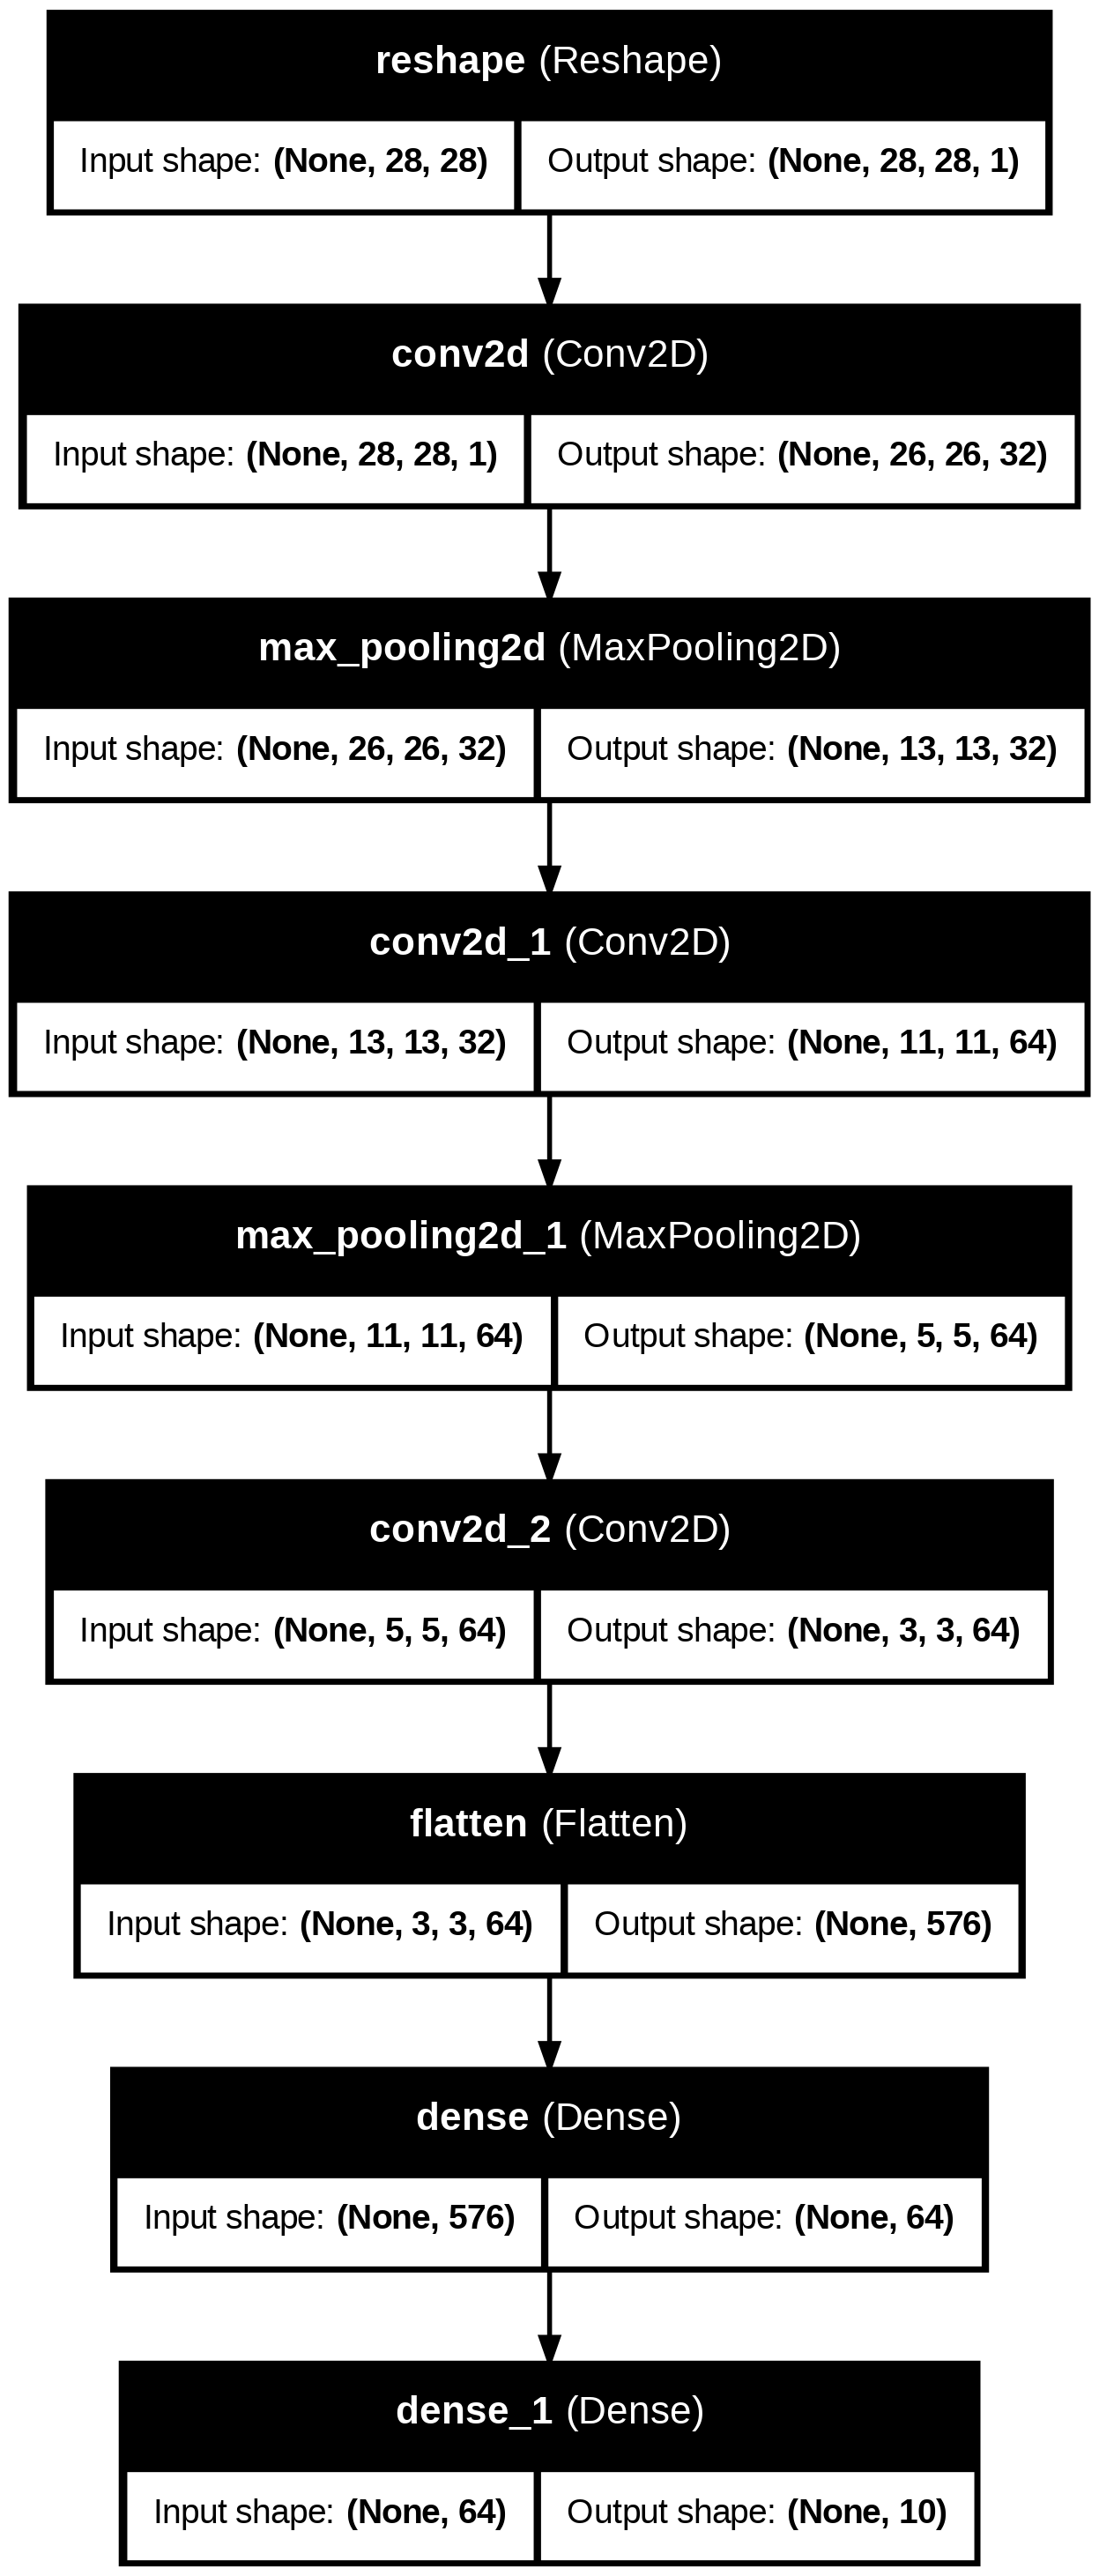

In [ ]:
# Defining the base model

# Initialize a sequential model to stack layers in a linear format.
model1 = models.Sequential([
    # Reshape the input to (28, 28, 1) to add a channel dimension for grayscale images
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    # First convolutional layer with 32 filters of size 3x3, using ReLU activation, and setting the input shape.
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # First max pooling layer with a pool size of 2x2 to reduce the spatial dimensions.
    layers.MaxPooling2D((2, 2)),
    # Second convolutional layer with 64 filters of size 3x3, using ReLU activation.
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Second max pooling layer with a pool size of 2x2.
    layers.MaxPooling2D((2, 2)),
    # Third convolutional layer with 64 filters of size 3x3, using ReLU activation.
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Flatten the output from the convolutional layers to feed into the dense layers.
    layers.Flatten(),
    # Dense layer with 64 units and ReLU activation.
    layers.Dense(64, activation='relu'),
    # Output layer with 10 units (for the 10 classes) with no activation function specified yet.
    layers.Dense(10)
])

# Generate a plot of the model
plot_model(model1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Assuming class_names represents the actual labels in your dataset
num_classes = len(class_names)
# Initialize a sequential model to stack layers in a linear format.
model1 = models.Sequential([
    # Reshape the input to (28, 28, 1) to add a channel dimension for grayscale images
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    # First convolutional layer with 32 filters of size 3x3, using ReLU activation, and setting the input shape.
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # First max pooling layer with a pool size of 2x2 to reduce the spatial dimensions.
    layers.MaxPooling2D((2, 2)),
    # Second convolutional layer with 64 filters of size 3x3, using ReLU activation.
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Second max pooling layer with a pool size of 2x2.
    layers.MaxPooling2D((2, 2)),
    # Third convolutional layer with 64 filters of size 3x3, using ReLU activation.
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Flatten the output from the convolutional layers to feed into the dense layers.
    layers.Flatten(),
    # Dense layer with 64 units and ReLU activation.
    layers.Dense(num_classes, activation='relu'),
    # Output layer with 24 units (for the 24 classes)
    layers.Dense(num_classes) # Changed from 10 to 24
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model1.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Reshape the training and testing images to (28, 28, 1) before fitting the model
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

In [ ]:
# fit the model
# history = model1.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[early_stopping])

# fit the model
# Ensure your training and validation data is of type float32
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)
train_labels = train_labels.astype(np.int32)  # or np.int64 if needed
test_labels = test_labels.astype(np.int32)  # or np.int64 if needed

history = model1.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.0456 - loss: 3.2252 - val_accuracy: 0.0446 - val_loss: 3.1803
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.0434 - loss: 3.1797 - val_accuracy: 0.0437 - val_loss: 3.1787
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.0457 - loss: 3.1788 - val_accuracy: 0.0471 - val_loss: 3.1770
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.0479 - loss: 3.1773 - val_accuracy: 0.0466 - val_loss: 3.1759
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.0626 - loss: 3.0972 - val_accuracy: 0.3053 - val_loss: 2.1265
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.3424 - loss: 1.9843 - val_accuracy: 0.4355 - val_loss: 1.6468
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4662 - loss: 1.5753 - val_accuracy: 0.5249 - val_loss: 1.4076
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.5332 - loss: 1.3824 - 

In [ ]:
# Model 1
test_loss, test_accuracy = model1.evaluate(test_images, test_labels, verbose=2)
print("Test Accuracy:", test_accuracy)

858/858 - 13s - 15ms/step - accuracy: 0.6244 - loss: 1.1136
Test Accuracy: 0.6244035959243774


In [ ]:
# Predict th model
y_pred = model1.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [ ]:
# model 1
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1126
           1       0.83      0.92      0.87      1010
           2       0.96      0.76      0.85      1144
           3       0.52      0.69      0.59      1196
           4       0.71      0.75      0.73       957
           5       0.66      0.81      0.73      1204
           6       0.67      0.70      0.69      1090
           7       0.59      0.87      0.71      1013
           8       0.47      0.51      0.49      1162
          10       0.54      0.55      0.55      1114
          11       0.68      0.71      0.70      1241
          12       0.38      0.27      0.32      1055
          13       0.43      0.54      0.48      1151
          14       0.84      0.87      0.85      1196
          15       0.87      0.93      0.90      1088
          16       0.85      0.69      0.76      1279
          17       0.53      0.60      0.56      1294
          18       0.46    

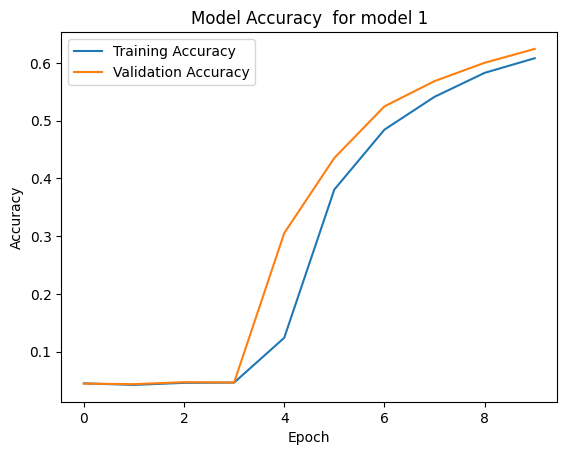

In [ ]:
# Model 1
# Plotting for training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy  for model 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Model 1
# Save the trained model to a file in HDF5 format, allowing easy storage of large numerical data.
model1.save('my_model1.h5')
# Print confirmation that the model was saved successfully.
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# model 1
#  Load the model saved in HDF5 format. This model is now ready to be used for inference or further training.
loaded_model1 = tensorflow.keras.models.load_model('my_model1.h5')

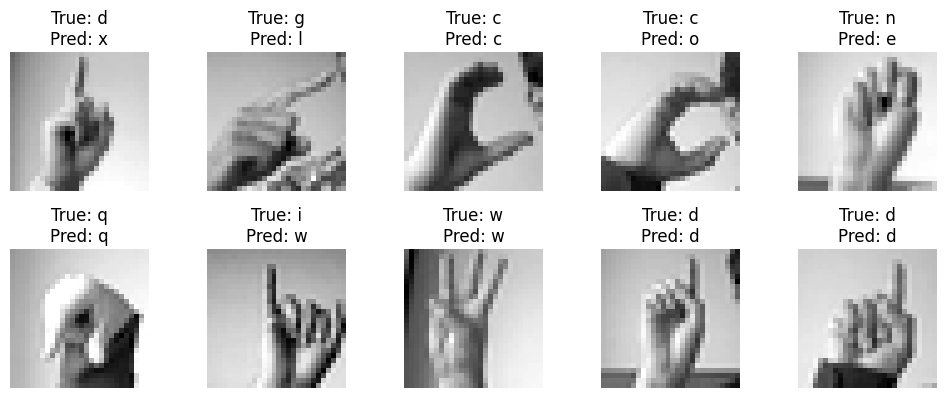

In [ ]:
# model 1
# Function to plot test images with predictions
def plot_predictions(train_images, unique_labels, train_labels, class_names, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'True: {class_names[unique_labels[i]]}\nPred: {class_names[train_labels[i]]}')
    plt.tight_layout()
    plt.show()

# Plot the first 10 test images with their true and predicted labels
plot_predictions(test_images, test_labels , y_pred_classes,  class_names, num_images=10)

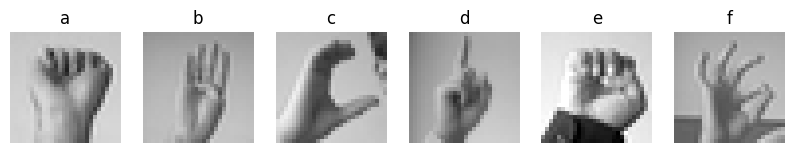

In [ ]:
def display_text_as_images(text):
    images_to_display = []
    for char in text.lower():
        if char in class_names:
            # Get the index of the character in class_names
            char_index = class_names.index(char)

            # Find an image in the dataset corresponding to the character
            image_row = asl_data[asl_data['label'] == char_index].iloc[0]  # Get the first matching row
            image_data = image_row.loc['pixel1':'pixel784'].values.reshape(28, 28)  # Reshape to 28x28

            # Convert image data to RGB format for display
            image_rgb = cv2.cvtColor(image_data.astype(np.uint8), cv2.COLOR_GRAY2RGB)
            images_to_display.append(image_rgb)
        else:
            print(f"Character '{char}' not found in the dataset.")

    # Display images side-by-side using matplotlib
    if images_to_display:
        fig, axes = plt.subplots(1, len(images_to_display), figsize=(10, 5))
        for i, img in enumerate(images_to_display):
            axes[i].imshow(img)
            axes[i].set_title(text[i])  # Set title as the original character
            axes[i].axis('off')  # Hide axes
        plt.show()

# Get text input from the user
# text_input = input("Enter text: ")
text_input = "abcdef" # @param {type: "string"}
# Display the text as images
display_text_as_images(text_input)


In [88]:
# function to capture and save images

def capture_and_save(value, num_samples=100):
  # capturing image from camera and saves them with labels

  # Google Drive directory path
  drive_dir = '/content/drive/MyDrive/Colab Notebooks/'
  value_dir = os.path.join(drive_dir, value)

  # creating directory if it does not exist
  if not os.path.exists(value_dir):
    os.makedirs(value_dir)

  cap = cv2.VideoCapture(0) # 0 for default camera
  count = 0

  while count < num_samples:
    ret, frame = cap.read()

    if ret:
      #Display a window with instructions
      cv2.putText(frame, f"Show sign for '{value} ({count + 1}/{num_sample})",
                  (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
      cv2.imshow('Capture Sign', frame)

      key = cv2.waitkey(1)
      if key == ord('s'): # Press 's' to save the image
        img_path = os.path.join(value_dir, f"{value}_{count}.jpg")
        cv2.imwrite(img_path, frame)
        print(f"Image saved: {img_path}")
        count += 1
      elif key == ord('q'): # Press 'q' to quit
        break

  cap.release()
  cv2.destroyAllWindows()



In [89]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [90]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [91]:
from IPython.display import display, Javascript, Image, HTML # Added HTML
from google.colab.output import eval_js
def take_photo(filename='photo.jpg', quality=0.8):
  # Create HTML buttons
  buttons_html = """
  <button id="openCameraBtn">Open Camera</button>
  <button id="closeCameraBtn" disabled>Close Camera</button>
  <div id="liveView"></div>
  """
  display(HTML(buttons_html))

  js = Javascript("""
    async function openCamera() {
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.getElementById('liveView').appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Enable close button, disable open button
      document.getElementById('closeCameraBtn').disabled = false;
      document.getElementById('openCameraBtn').disabled = true;

      // Function to capture photo
      window.capturePhoto = async function() {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        return canvas.toDataURL('image/jpeg', """ + str(quality) + """);
      }
    }

    function closeCamera() {
      const video = document.getElementById('liveView').querySelector('video');
      if (video) {
        const stream = video.srcObject;
        if (stream) {
          stream.getTracks().forEach(track => track.stop());
        }
        video.remove();
      }
      // Enable open button, disable close button
      document.getElementById('closeCameraBtn').disabled = true;
      document.getElementById('openCameraBtn').disabled = false;
    }

    document.getElementById('openCameraBtn').onclick = openCamera;
    document.getElementById('closeCameraBtn').onclick = closeCamera;
  """)
  display(js)



In [92]:
from google.colab import drive
import cv2
import os

# Mount Google Drive
drive.mount('/content/drive')

def capture_and_save_to_drive(value, num_samples=100):
    """Captures images from camera and saves them to Google Drive."""

    # Google Drive directory path
    drive_dir = '/content/drive/MyDrive/Colab Notebooks/captured_images/'  # Adjust the path as needed
    value_dir = os.path.join(drive_dir, value)

    # Create directory if it doesn't exist
    os.makedirs(value_dir, exist_ok=True)

    cap = cv2.VideoCapture(0)  # 0 for default camera

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    count = 0
    while count < num_samples:
        ret, frame = cap.read()

        if ret:
            # Display instructions
            cv2.putText(frame, f"Show sign for '{value}' ({count + 1}/{num_samples})",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.imshow('Capture Sign', frame)

            key = cv2.waitKey(1)
            if key == ord('s'):
                img_path = os.path.join(value_dir, f"{value}_{count}.jpg")
                cv2.imwrite(img_path, frame)
                print(f"Image saved: {img_path}")
                count += 1
            elif key == ord('q'):
                break
        else:
            print("Error: Could not capture frame.")
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
missing_values = ['j', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for value in missing_values:
    capture_and_save_to_drive(value)
    print(f"Images captured for '{value}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: Could not open camera.
Images captured for 'j'
Error: Could not open camera.
Images captured for 'z'
Error: Could not open camera.
Images captured for '0'
Error: Could not open camera.
Images captured for '1'
Error: Could not open camera.
Images captured for '2'
Error: Could not open camera.
Images captured for '3'
Error: Could not open camera.
Images captured for '4'
Error: Could not open camera.
Images captured for '5'
Error: Could not open camera.
Images captured for '6'
Error: Could not open camera.
Images captured for '7'
Error: Could not open camera.
Images captured for '8'
Error: Could not open camera.
Images captured for '9'


In [ ]:
import cv2

# Initialize the camera
cap = cv2.VideoCapture(0)  # 0 usually refers to the default webcam

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Capture a frame
ret, frame = cap.read()

# Check if the frame was captured successfully
if ret:
    # Display the captured frame in a window
    cv2.imshow('Captured Image', frame)

    # Save the captured frame to a file (optional)
    cv2.imwrite('captured_image.jpg', frame)
    print("Image captured and saved to 'captured_image.jpg'")

    # Wait for a key press and then close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Could not capture frame.")

# Release the camera
cap.release()

Error: Could not open camera.
Error: Could not capture frame.
